In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from IPython.display import HTML
import scipy.stats as stats
from scipy import sparse

# Finite Volume Methods
Starting from pg100 in Leveque Finite Volume Methods.
## Derivation
### Fluxes
If we split the x-axis into *cells* which are $\Delta x$ wide and centre on $k\Delta x$ where $k\in\mathbb{N}$ then we can take the *cell average* for each cell. We will write this as
$$
U_i^n=\frac{1}{\Delta x}\int_{x_{i-1/2}}^{x_{i+1/2}}u_x^ndx
$$
where $u_x^n$ denotes the solution at point $x$ at time $n$.
We can safely assume that there must be a constant volume of particles and thus, a constant area under the curve. So, if $A$ is the area under the curve
$$
\partial_tA=0
$$
then, we can imagine particles moving between cells. This concept leads us to the formula,
$$
U_i^{n+1}=U_i^n-\frac{\Delta t}{\Delta x}(F_{i+1/2}^n-F_{i-1/2}^n)
$$
where $F_{i\pm 1/2}^n$ denotes the *fluxes* in and out of cell $i$. Now we need to find a way to define these fluxes. In order to find one we can look back to our finite difference methods.
Now, taking the Lax-Wendroff method,
$$
U_i^{n+1}=U_i^n-\frac{a\Delta t}{2\Delta x}(U_{i+1}^n-U_{i-1}^n)+\left(\frac{a\Delta t}{\sqrt{2}\Delta x}\right)^2(U_{i-1}^n-2U_i^n+U_{i+1}^n)
$$
We can reinterpret it as a finite volume method with the fluxes,
$$
F_{i-1/2}^n=aU_{i-1}^n-\frac{a}{2}(1-c)(U_i^n-U_{i-1}^n), \quad F_{i+1/2}^n=aU_{i}^n-\frac{a}{2}(1-c)(U_{i+1}^n-U_{i}^n)
$$
where $c=\frac{a\Delta t}{\Delta x}$ is the courant number. We call the above fluxes *second order*, $F_H$, while the *first order* fluxes, $F_L$, are defined as follows.
$$
F_{i-1/2}^n=aU_{i-1}^n, \quad F_{i+1/2}^n=aU_{i}^n
$$
### Limiters
It is important to note that first order methods and second order methods have different stengths and weaknesses **include examples/flesh out**. So, as found in (Harten and Zwas, 1972, p.568), we can introduce a flux-limiter equation. This equation uses a limiter, $\Phi$, which changes how much either the second or first order part of the method affects the outcome.
$$
F_{i-1/2}^n=F_L+\Phi_{i-1/2}^n(F_H-F_L)
$$
So, if $\Phi=0$ then we simply have a first order upwind method and when $\Phi=1$ we have a purely second order method. However, there is a much more useful definition for $\Phi$. We will say that $\Phi_{i-1/2}^n=\phi(\theta_{i-1/2}^n)$. We define $\theta_{i-1/2}^n$ as follows.
$$
\theta_{i-1/2}^n=\frac{U_{i-1}^n-U_{i-2}^n}{U_i^n-U_{i-1}^n}
$$
We will define some functions for $\Phi$ later.

In [2]:
## Graph times
def js1(Ts):
    return [0,int(np.round(Ts/10, 0)),int(np.round(Ts/2, 0)),int(np.round(Ts-1, 0))]

## Initial Conditions
def tophat(Ms):
    return [1 if i>int(3*Ms/8) and i<int(5*Ms/8) else 0 for i in range(Ms)]

def normcurve(Ms):
    mu = int(Ms/2) # Peak value for the normal curve
    sig = int(Ms/20) # Variance for normal curve
    xa=np.linspace(0,Ms-1,Ms)
    return stats.norm.pdf(xa, mu, sig)/max(stats.norm.pdf(xa, mu, sig)) # Normal curve centred at mu with variance sig

In [3]:
## Limiters
def minmod(theta):
    return np.max([0, np.min([1, theta])])

def superbee(theta):
    return np.max([0, np.min([1, 2*theta]), np.min([2, theta])])

def upwind(theta):
    return 0

def LWendroff(theta):
    return 1

def vanleer(theta):
    return (theta+abs(theta))/(1+abs(theta))

In [4]:
def lwuwGraph(M, T, dx, dt, a, js, ics, phi, name):
    ## Flux-limiter implementation using Lax-Wendroff and Upwind
    ## Find sizes for matrices
    Ms = int(M/dx)
    Ts = int(T/dt)+1
    
    ## Initial matrix
    u = np.zeros((Ms,Ts))
    u[:,0]=ics(Ms)
    
    ## Find particle density for each timestep
    for t in range(Ts):
        for x in range(Ms):
            u[x,t]=u[int(np.round(((x*dx)-(a*t*dt))/dx, 0))%Ms,0]
            
    ## Initial matrix
    ua = np.zeros((Ms,Ts))
    ua[:,0]=ics(Ms)
    
    ## Calculation
    for n in range(Ts-1):
        for i in range(Ms):
            Fh = a*(1-(dt*a/dx))*(ua[i,n]-ua[i-1,n])/2
            if abs(ua[i-1,n]-ua[i-2,n])<0.0001:
                Fm = a*ua[i-1,n]+phi(0)*Fh
            elif abs(ua[i,n]-ua[i-1,n])<0.0001:
                theta = (ua[i-1,n]-ua[i-2,n])/(ua[i,n]-ua[i-1,n]+0.0001)
                Fm = a*ua[i-1,n]+phi(theta)*Fh
            else: 
                theta = (ua[i-1,n]-ua[i-2,n])/(ua[i,n]-ua[i-1,n])
                Fm = a*ua[i-1,n]+phi(theta)*Fh
                
            Fh = a*(1-(dt*a/dx))*(ua[(i+1)%Ms,n]-ua[i,n])/2
            if abs(ua[i,n]-ua[i-1,n])<0.0001:
                Fp = a*ua[i,n]+phi(0)*Fh
            elif abs(ua[(i+1)%Ms,n]-ua[i,n])<0.0001:
                theta = (ua[i,n]-ua[i-1,n])/(ua[(i+1)%Ms,n]-ua[i,n]+0.001)
                Fp = a*ua[i,n]+phi(theta)*Fh
            else:
                theta = (ua[i,n]-ua[i-1,n])/(ua[(i+1)%Ms,n]-ua[i,n])
                Fp = a*ua[i,n]+phi(theta)*Fh
            ua[i,n+1]=ua[i,n]-(dt/dx)*(Fp-Fm)
    
    ## Plot graphs
    maxi = np.max(ua[:,0])*1.1
    fig, axs = plt.subplots(1, 4, figsize=(13,3))
    fig.tight_layout()
    fig.subplots_adjust(top=0.8)
    for ax, j in zip(axs, js(Ts)):
        ax.set_title("T="+str(j*dt))
        ax.set(xlim=(0, M), ylim=(-maxi, maxi))
        ax.plot(np.arange(0,M,M/Ms), ua[:,j])
        ax.plot(np.arange(0,M,M/Ms), u[:,j], ':')

## Graphs of different Limiter methods
### Upwind Limiter
By letting $\phi=0$ we can check that our scheme acts exactly like the upwind method.

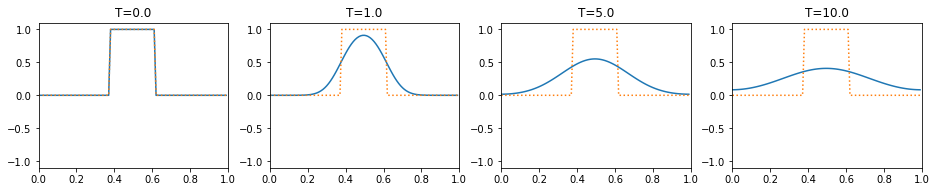

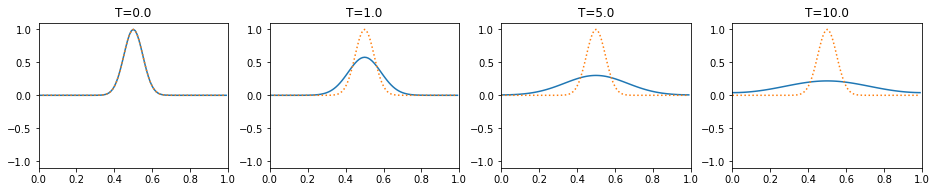

In [5]:
lwuwGraph(1, 10,  0.01,  0.005,  1, js1, tophat, upwind, "Upwind")
lwuwGraph(1, 10,  0.01,  0.005,  1, js1, normcurve, upwind, "Upwind")

### Lax-Wendroff Limiter
By letting $\phi=1$ we can see that our scheme acts exactly like the Lax-Wendroff method.

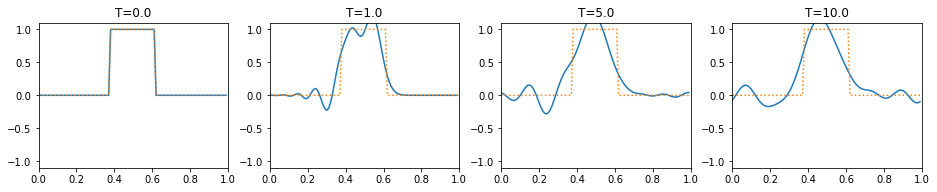

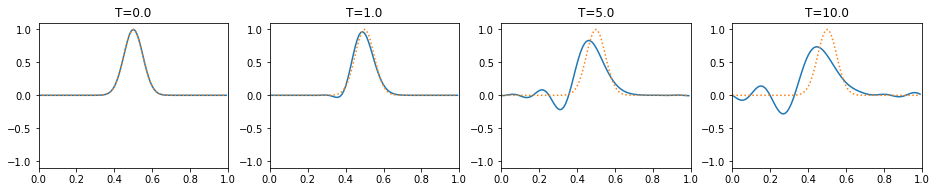

In [6]:
lwuwGraph(1, 10,  0.01,  0.005,  1, js1, tophat, LWendroff, "Lax-Wendroff")
lwuwGraph(1, 10,  0.01,  0.005,  1, js1, normcurve, LWendroff, "Lax-Wendroff")

### Minmod Limiter
By setting $\phi(\theta)=\text{minmod}(1, \theta)$ where,
$$
\text{minmod}(b, c) =
\begin{cases}
b \quad\text{if $|b|<|c|$ and $bc>0$}\\
c \quad\text{if $|c|<|b|$ and $bc>0$}\\
0 \quad\text{if $bc\leq 0$}
\end{cases}
$$

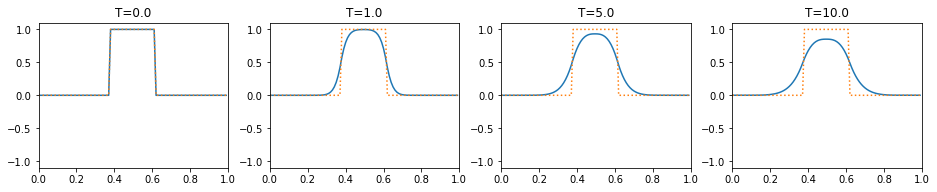

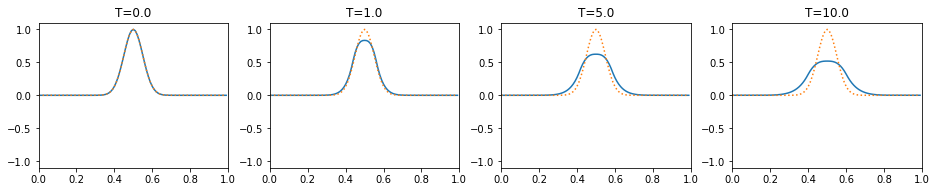

In [7]:
lwuwGraph(1, 10,  0.01,  0.005,  1, js1, tophat, minmod, "Minmod")
lwuwGraph(1, 10,  0.01,  0.005,  1, js1, normcurve, minmod, "Minmod")

### Superbee Limiter
By setting $\phi(\theta)=\max(0, \min(1,2\theta), \min(2,\theta))$ we can further improve on the accuracy of the minmod limiter.

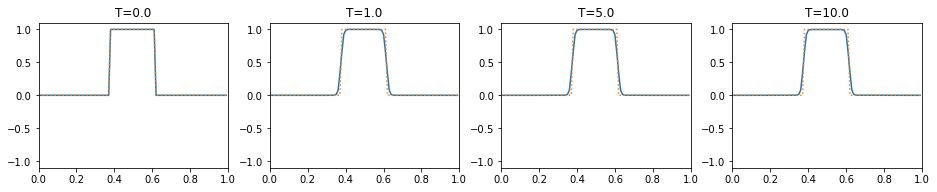

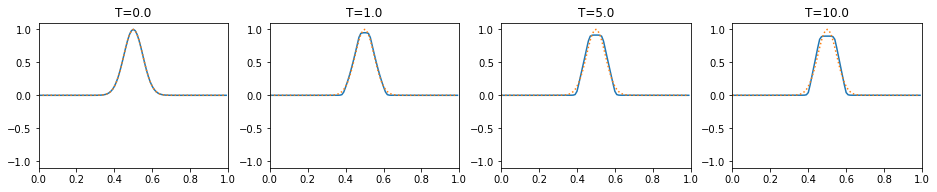

In [8]:
lwuwGraph(1, 10,  0.01,  0.005,  1, js1, tophat, superbee, "Superbee")
lwuwGraph(1, 10,  0.01,  0.005,  1, js1, normcurve, superbee, "Superbee")

### van Leer Limiter
$$
\phi(\theta)=\frac{\theta+|\theta|}{1+|\theta|}
$$


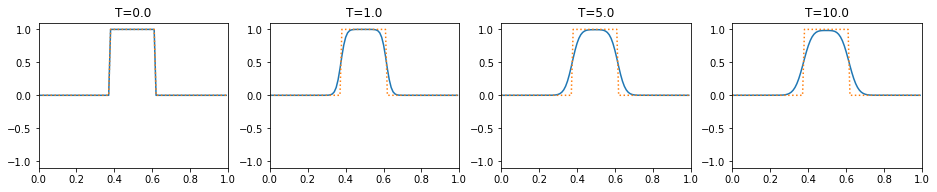

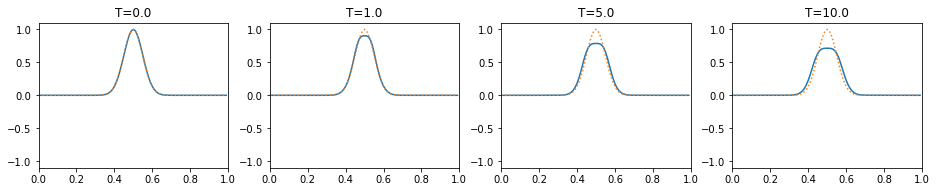

In [9]:
lwuwGraph(1, 10,  0.01,  0.005,  1, js1, tophat, vanleer, "van Leer")
lwuwGraph(1, 10,  0.01,  0.005,  1, js1, normcurve, vanleer, "van Leer")